# <p style="text-align: center;"> Charter school identities and outcomes in the accountability era:<br/> Preliminary results

<p style="text-align: center;">![alt text](http://jaypgreene.files.wordpress.com/2009/12/explosion_600x625600x625.jpg "Old U.S. Map of charter schools by state")
<p style="text-align: center;">(this out-dated graphic courtesy of U.S. News & World Report, 2009)

## Research questions
**How are charter schools different from each other in terms of ideology? How do these differences shape their survival and their outcomes, and what does this reveal about current educational policy?** 

## The corpus
- Website self-descriptions of all **6,753 charter schools** open in 2014-15 (identified using the NCES Public School Universe Survey)
- Charter school websites are a publicly visible proclamation of identity attempting to impress parents, regulators, etc.
- This study the first to use this contemporary, comprehensive data source on U.S. charter school identities
- Me & research team working on using BeautifulSoup and requests.get to webscrape the full sample

### Motivation
- Too much focus on test scores in education, too little on organizational aspects
- Are charter schools innovative? How?
- How does educational policy shape ed. philosophy? Organization? Outcomes?
- No one has studied charters' public image as expressed in their OWN words

### Methods
- NLP: Word frequencies, distinctive words, etc.
- Supervised: Custom dictionaries
- Unsupervised: Topic models, word embeddings
- Later: statistical regression to test, e.g., how progressivist schools in liberal communities have higher performance than they do in other places

## Preliminary analysis: website self-descriptions of non-random sample of 196 schools
- Early-stage sample: NOT representative!
- About half randomly selected, half tracked down (many through Internet Archive) because of missing URLs
- Closed schools over-represented

## Initializing Python

In [1]:
#!/usr/bin/env python
# -*- coding: UTF-8

In [2]:
# IMPORTING KEY PACKAGES
import csv # for reading in CSVs and turning them into dictionaries
import re # for regular expressions
import os # for navigating file trees
import nltk # for natural language processing tools
import pandas # for working with dataframes
import numpy as np # for working with numbers

In [3]:
# FOR CLEANING, TOKENIZING, AND STEMMING THE TEXT
from nltk import word_tokenize, sent_tokenize # widely used text tokenizer
from nltk.stem.porter import PorterStemmer # an approximate method of stemming words (it just cuts off the ends)
from nltk.corpus import stopwords # for one method of eliminating stop words, to clean the text
stopenglish = list(stopwords.words("english")) # assign the string of english stopwords to a variable and turn it into a list
import string # for one method of eliminating punctuation
punctuations = list(string.punctuation) # assign the string of common punctuation symbols to a variable and turn it into a list

In [4]:
# FOR ANALYZING WITH THE TEXT
from sklearn.feature_extraction.text import CountVectorizer # to work with document-term matrices, especially
countvec = CountVectorizer(tokenizer=nltk.word_tokenize)
from sklearn.feature_extraction.text import TfidfVectorizer # for creating TF-IDFs
tfidfvec = TfidfVectorizer()
from sklearn.decomposition import LatentDirichletAllocation # for topic modeling

import gensim # for word embedding models
from scipy.spatial.distance import cosine # for cosine similarity
from sklearn.metrics import pairwise # for pairwise similarity
from sklearn.manifold import MDS, TSNE # for multi-dimensional scaling

In [5]:
# FOR VISUALIZATIONS
import matplotlib
import matplotlib.pyplot as plt

# Visualization parameters
% pylab inline 
% matplotlib inline
matplotlib.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


## Reading in preliminary data

In [6]:
sample = [] # make empty list
with open('../data_URAP_etc/mission_data_prelim.csv', 'r', encoding = 'Latin-1')\
as csvfile: # open file                      
    reader = csv.DictReader(csvfile) # create a reader
    for row in reader: # loop through rows
        sample.append(row) # append each row to the list

In [8]:
sample[0]

{'ADDRESS': '308 SOUTH BLAKE ST, PINE BLUFF, AR',
 'AM': '0',
 'AM01F': '-2',
 'AM01M': '-2',
 'AM02F': '-2',
 'AM02M': '-2',
 'AM03F': '-2',
 'AM03M': '-2',
 'AM04F': '-2',
 'AM04M': '-2',
 'AM05F': '0',
 'AM05M': '0',
 'AM06F': '0',
 'AM06M': '0',
 'AM07F': '0',
 'AM07M': '0',
 'AM08F': '0',
 'AM08M': '0',
 'AM09F': '-2',
 'AM09M': '-2',
 'AM10F': '-2',
 'AM10M': '-2',
 'AM11F': '-2',
 'AM11M': '-2',
 'AM12F': '-2',
 'AM12M': '-2',
 'AMALF': '0',
 'AMALM': '0',
 'AMKGF': '-2',
 'AMKGM': '-2',
 'AMPKF': '-2',
 'AMPKM': '-2',
 'AMUGF': '-2',
 'AMUGM': '-2',
 'AS01F': '-2',
 'AS01M': '-2',
 'AS02F': '-2',
 'AS02M': '-2',
 'AS03F': '-2',
 'AS03M': '-2',
 'AS04F': '-2',
 'AS04M': '-2',
 'AS05F': '0',
 'AS05M': '0',
 'AS06F': '0',
 'AS06M': '0',
 'AS07F': '0',
 'AS07M': '0',
 'AS08F': '0',
 'AS08M': '0',
 'AS09F': '-2',
 'AS09M': '-2',
 'AS10F': '-2',
 'AS10M': '-2',
 'AS11F': '-2',
 'AS11M': '-2',
 'AS12F': '-2',
 'AS12M': '-2',
 'ASALF': '0',
 'ASALM': '0',
 'ASIAN': '0',
 'ASKGF': '-2',

In [7]:
# Take a look at the most important contents and the variables list
# in our sample (a list of dictionaries)--let's look at just the first entry
print(sample[1]["SCHNAM"], "\n", sample[1]["URL"], "\n", sample[1]["WEBTEXT"], "\n")
print(sample[1].keys()) # look at all the variables!

THE ACADEMIES AT JONESBORO HIGH SCHOOL 
 http://www.jonesboroschools.net/schools/academies_at_jonesboro_high_school 
 The mission of the Academies at Jonesboro High School is to provide a high quality, research-based education for all students in order to equip them with the essential skills necessary to be successful in todayÕs changing global community. Through strong partnerships with business and community stakeholders, the Academies at Jonesboro High School will ensure high achievement in all subjects through an expanded curriculum and the use of data-driven methods to evaluate and implement proven instructional strategies. The Academies at JHS will foster respect for global diversity and maintain a commitment to create exceptional opportunities for the educational growth of every child.  Excellence is our Standard, not our Goal, for All Students   

dict_keys(['AM12F', 'AM08M', 'AMPKF', 'TR09F', 'AM07M', 'BL02M', 'BL10F', 'G07OFFRD', 'G05', 'G08', 'STATUS', 'SFTEPUP', 'HIPKF', 'I

In [8]:
# Read the data in as a pandas dataframe
df = pandas.read_csv("../data_URAP_etc/mission_data_prelim.csv", encoding = 'Latin-1')
df = df.dropna(subset=["WEBTEXT"]) # drop any schools with no webtext that might have snuck in (none currently)

In [9]:
# Add additional variables for analysis:
# PCTETH = percentage of enrolled students belonging to a racial minority
# this includes American Indian, Asian, Hispanic, Black, Hawaiian, or Pacific Islander
df["PCTETH"] = (df["AM"] + df["ASIAN"] + df["HISP"] + df["BLACK"] + df["PACIFIC"]) / df["MEMBER"]

df["STR"] = df["MEMBER"] / df["FTE"] # Student/teacher ratio
df["PCTFRPL"] = df["TOTFRL"] / df["MEMBER"] # Percent of students receiving FRPL

# Another interesting variable: 
# TYPE = type of school, where 1 = regular, 2 = special ed, 3 = vocational, 4 = other/alternative, 5 = reportable program

In [10]:
## Print the webtext from the first school in the dataframe
print(df.iloc[0]["WEBTEXT"])

Quest is a public school chartered by the State Board of Education. As a public school, the campus has the responsibility to ensure all students meet the standards created by the Texas Education Agency. 


## Descriptive statistics

### How urban proximity is coded: Lower number = more urban (closer to large city) 

More specifically, it uses two digits with distinct meanings: 
- the first digit: 
    - 1 = city
    - 2 = suburb
    - 3 = town
    - 4 = rural
- the second digit:
    - 1 = large or fringe
    - 2 = mid-size or distant
    - 3 = small/remote

In [11]:
print(df.describe()) # get descriptive statistics for all numerical columns
print()
print(df['ULOCAL'].value_counts()) # frequency counts for categorical data
print()
print(df['LEVEL'].value_counts()) # treat grade range served as categorical
# Codes for level/ grade range served: 3 = High school, 2 = Middle school, 1 = Elementary, 4 = Other)
print()
print(df['LSTATE'].mode()) # find the most common state represented in these data
print(df['ULOCAL'].mode()) # find the most urbanicity represented in these data

       SURVYEAR       NCESSCH       FIPST           LEAID         SCHNO  \
count       196  1.960000e+02  196.000000      196.000000    196.000000   
mean       2013  2.510655e+11   25.035714  2511089.642857   5845.489796   
std           0  1.771059e+11   17.759468  1771302.884773   4214.934368   
min        2013  4.001010e+10    4.000000   400101.000000     16.000000   
25%        2013  6.402526e+10    6.000000   640252.500000   2243.500000   
50%        2013  2.500000e+11   25.000000  2500284.000000   4600.500000   
75%        2013  4.200000e+11   42.000000  4200094.500000   8657.250000   
max        2013  5.510000e+11   55.000000  5514220.000000  13727.000000   

              PHONE          MZIP        MZIP4         LZIP        LZIP4  \
count  1.960000e+02    196.000000   141.000000    196.00000   141.000000   
mean   5.800643e+09  61181.617347  2800.822695  61034.77551  2700.843972   
std    2.457133e+09  27190.843275  2819.455282  27277.06302  2724.089340   
min    2.022488e+09 

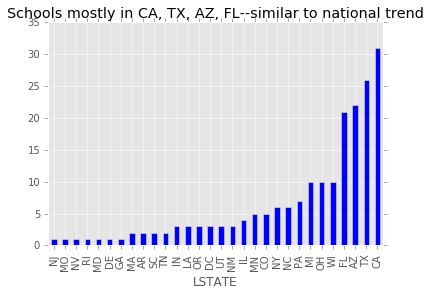

In [12]:
# here's the number of schools from each state, in a graph:
grouped_state = df.groupby('LSTATE')
grouped_state['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Schools mostly in CA, TX, AZ, FL--similar to national trend')
plt.show()

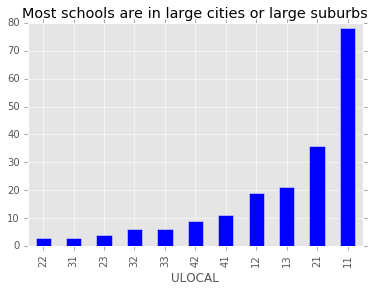

In [13]:
# and here's the number of schools in each urban category, in a graph:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['WEBTEXT'].count().sort_values(ascending=True).plot(kind = 'bar', title='Most schools are in large cities or large suburbs')
plt.show()

#### What these numbers say about the charter schools in the sample:
- Most are located in large cities, followed by large suburbs, then medium and small city, and then rural.
- The means for percent minorities and students receiving free- or reduced-price lunch are both about 60%.
- Most are in CA, TX, AZ, and FL
- Most of the schools in the sample are primary schools

#### This means that the sample reflects national averages. In that sense, this sample isn't so bad.

## Cleaning, tokenizing, and stemming the text

In [14]:
# Now we clean the webtext by rendering each word lower-case then removing punctuation. 
df['webtext_lc'] = df['WEBTEXT'].str.lower() # make the webtext lower case
df['webtokens'] = df['webtext_lc'].apply(nltk.word_tokenize) # tokenize the lower-case webtext by word
df['webtokens_nopunct'] = df['webtokens'].apply(lambda x: [word for word in x if word not in list(string.punctuation)]) # remove punctuation

In [15]:
print(df.iloc[0]["webtokens"]) # the tokenized text without punctuation

['quest', 'middle', 'schools¨', 'are', 'schools', 'focused', 'on', 'high', 'expectations', 'for', 'behavior', 'and', 'academics', '.', 'students', 'must', 'work', 'hard', 'to', 'meet', 'their', 'goals', '.', 'to', 'fully', 'succeed', 'in', 'a', 'quest', 'middle', 'school', ',', 'students', 'must', 'consistently', 'show', 'leadership', 'skills', ',', 'good', 'behavior', ',', 'and', 'a', 'work', 'ethic', 'to', 'meet', 'expectations', '.', 'beyond', 'this', ',', 'quest', 'schools', 'provides', 'curriculum', 'designed', 'to', 'teach', 'wisdom', '.', 'knowledge', 'is', 'crucial', ',', 'but', 'wisdom', 'is', 'a', 'vital', 'part', 'of', 'a', 'middle', 'school', 'studentõs', 'growth', 'and', 'maturity', '.', 'character', 'education', 'is', 'taught', 'at', 'all', 'levels', '.', 'students', 'are', 'taught', 'leadership', 'skills', 'through', 'our', '7', 'habits', 'of', 'highly', 'effective', 'teens*', 'environment', '.', 'our', 'administrators', 'and', 'teachers', 'care', 'about', 'students', 'a

In [16]:
# Now we remove stopwords and stem. This will improve the results
df['webtokens_clean'] = df['webtokens_nopunct'].apply(lambda x: [word for word in x if word not in list(stopenglish)]) # remove stopwords
df['webtokens_stemmed'] = df['webtokens_clean'].apply(lambda x: [PorterStemmer().stem(word) for word in x])

In [17]:
# Some analyses require a string version of the webtext without punctuation or numbers.
# To get this, we join together the cleaned and stemmed tokens created above, and then remove numbers and punctuation:
df['webtext_stemmed'] = df['webtokens_stemmed'].apply(lambda x: ' '.join(char for char in x))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if char not in punctuations))
df['webtext_stemmed'] = df['webtext_stemmed'].apply(lambda x: ''.join(char for char in x if not char.isdigit()))

In [18]:
df['webtext_stemmed'][0]

'quest middl schools¨ school focus high expect behavior academ student must work hard meet goal fulli succeed quest middl school student must consist show leadership skill good behavior work ethic meet expect beyond quest school provid curriculum design teach wisdom knowledg crucial wisdom vital part middl school studentõ growth matur charact educ taught level student taught leadership skill  habit highli effect teens environ administr teacher care student passion see reach full potenti provid qualiti educ student quest educ collabor make sure child receiv attent necessari success quest provid safe environ commit learn educ work student parent meet rigor academ standard quest combin teach knowledg wisdom quest middl school use varieti curriculum ensur middl school student solid foundat content learn tradit curriculum beyond quest middl school provid curriculum design teach wisdom knowledg crucial wisdom vital part middl school studentõ growth matur charact educ taught level student tau

In [19]:
# Some analyses require tokenized sentences. I'll do this with the list of dictionaries.
# I'll use cleaned, tokenized sentences (with stopwords) to create both a dictionary variable and a separate list for word2vec

words_by_sentence = [] # initialize the list of tokenized sentences as an empty list
for school in sample:
    school["sent_toksclean"] = []
    school["sent_tokens"] = [word_tokenize(sentence) for sentence in sent_tokenize(school["WEBTEXT"])] 
    for sent in school["sent_tokens"]:
        school["sent_toksclean"].append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)]) # for each word: stem, lower-case, and remove punctuations
        words_by_sentence.append([PorterStemmer().stem(word.lower()) for word in sent if (word not in punctuations)])

In [20]:
words_by_sentence[:2]

[['quest',
  'middl',
  'schools¨',
  'are',
  'school',
  'focus',
  'on',
  'high',
  'expect',
  'for',
  'behavior',
  'and',
  'academ'],
 ['student', 'must', 'work', 'hard', 'to', 'meet', 'their', 'goal']]

### Counting document lengths

In [21]:
# We can also count document lengths. I'll mostly use the version with punctuation removed but including stopwords,
# because stopwords are also part of these schools' public image/ self-presentation to potential parents, regulators, etc.

df['webstem_count'] = df['webtokens_stemmed'].apply(len) # find word count without stopwords or punctuation
df['webpunct_count'] = df['webtokens_nopunct'].apply(len) # find length with stopwords still in there (but no punctuation)
df['webclean_count'] = df['webtokens_clean'].apply(len) # find word count without stopwords or punctuation

In [22]:
# For which urban status are website self-description the longest?
print(grouped_urban['webpunct_count'].mean().sort_values(ascending=False))

ULOCAL
12    941.421053
22    780.000000
21    593.472222
41    576.909091
11    571.500000
13    530.809524
31    408.666667
33    364.500000
32    292.333333
42    257.444444
23    210.000000
Name: webpunct_count, dtype: float64


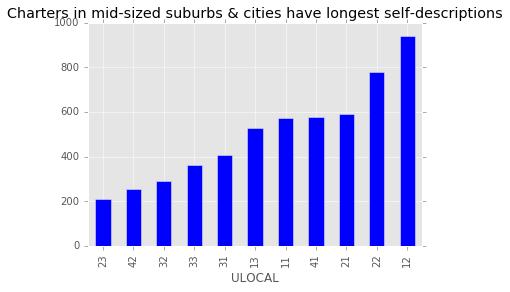

In [23]:
# here's the mean website self-description word count for schools grouped by urban proximity, in a graph:
grouped_urban['webpunct_count'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Schools in mid-sized cities and suburbs have longer self-descriptions than in fringe areas', yerr = grouped_state["webpunct_count"].std())
plt.show()

In [24]:
# Now let's calculate the type-token ratio (TTR) for each school, which compares
# the number of types (unique words used) with the number of words (including repetitions of words).

df['numtypes'] = df['webtokens_nopunct'].apply(lambda x: len(set(x))) # this is the number of unique words per site
df['TTR'] =  df['numtypes'] / df['webpunct_count'] # calculate TTR

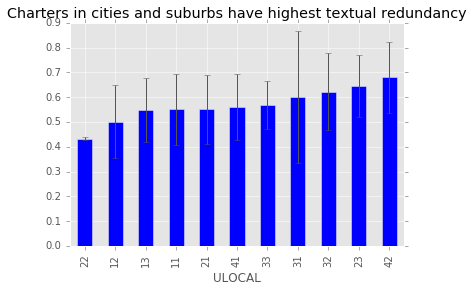

In [25]:
# here's the mean TTR for schools grouped by urban category:
grouped_urban = df.groupby('ULOCAL')
grouped_urban['TTR'].mean().sort_values(ascending=True).plot(kind = 'bar', title='Charters in cities and suburbs have higher textual redundancy than in fringe areas', yerr = grouped_urban["TTR"].std())
plt.show()

## (Excessively) Frequent words

In [26]:
# First, aggregate all the cleaned webtext:
webtext_all = []
df['webtokens_clean'].apply(lambda x: [webtext_all.append(word) for word in x])
webtext_all

['quest',
 'middle',
 'schools¨',
 'schools',
 'focused',
 'high',
 'expectations',
 'behavior',
 'academics',
 'students',
 'must',
 'work',
 'hard',
 'meet',
 'goals',
 'fully',
 'succeed',
 'quest',
 'middle',
 'school',
 'students',
 'must',
 'consistently',
 'show',
 'leadership',
 'skills',
 'good',
 'behavior',
 'work',
 'ethic',
 'meet',
 'expectations',
 'beyond',
 'quest',
 'schools',
 'provides',
 'curriculum',
 'designed',
 'teach',
 'wisdom',
 'knowledge',
 'crucial',
 'wisdom',
 'vital',
 'part',
 'middle',
 'school',
 'studentõs',
 'growth',
 'maturity',
 'character',
 'education',
 'taught',
 'levels',
 'students',
 'taught',
 'leadership',
 'skills',
 '7',
 'habits',
 'highly',
 'effective',
 'teens*',
 'environment',
 'administrators',
 'teachers',
 'care',
 'students',
 'passion',
 'see',
 'reach',
 'full',
 'potential',
 'providing',
 'quality',
 'education',
 'students',
 'quest',
 'educators',
 'collaborate',
 'make',
 'sure',
 'child',
 'receives',
 'attention',


In [27]:
# Now apply the nltk function FreqDist to count the number of times each token occurs.
word_frequency = nltk.FreqDist(webtext_all)

#print out the 50 most frequent words using the function most_common
print(word_frequency.most_common(50))

[('students', 1739), ('school', 1661), ('learning', 736), ('education', 539), ('charter', 476), ('community', 470), ('student', 466), ('high', 415), ('program', 395), ('academic', 390), ('schools', 344), ('academy', 342), ('curriculum', 340), ('college', 328), ('skills', 320), ('teachers', 295), ('children', 280), ('grade', 267), ('environment', 241), ('provide', 238), ('success', 226), ('educational', 224), ('every', 217), ('work', 213), ('staff', 207), ('support', 207), ('leadership', 198), ('year', 198), ('arts', 190), ('development', 185), ('parents', 185), ('develop', 184), ('learn', 183), ('state', 182), ('public', 182), ('grades', 176), ('standards', 174), ('needs', 170), ('core', 169), ('instruction', 169), ('science', 168), ('world', 153), ('programs', 152), ('mission', 152), ('life', 151), ('new', 150), ('opportunities', 150), ('one', 148), ('social', 148), ('also', 146)]


 ### These are prolific, ritual, empty words and will be excluded from topic models!

## Distinctive words (mostly place names)

In [28]:
sklearn_dtm = countvec.fit_transform(df['webtext_stemmed'])
print(sklearn_dtm)

  (0, 3848)	11
  (0, 3003)	8
  (0, 4223)	1
  (0, 4214)	13
  (0, 1883)	1
  (0, 2208)	1
  (0, 1703)	2
  (0, 456)	2
  (0, 25)	2
  (0, 4679)	9
  (0, 3130)	2
  (0, 5432)	3
  (0, 2157)	1
  (0, 2956)	4
  (0, 2045)	1
  (0, 1968)	1
  (0, 4716)	1
  (0, 1005)	1
  (0, 4380)	1
  (0, 2697)	3
  (0, 4438)	3
  (0, 2055)	1
  (0, 1646)	1
  (0, 480)	2
  (0, 3802)	4
  :	:
  (195, 1421)	1
  (195, 3963)	1
  (195, 3768)	1
  (195, 3894)	1
  (195, 2069)	1
  (195, 3020)	2
  (195, 4618)	1
  (195, 2060)	1
  (195, 3197)	1
  (195, 710)	1
  (195, 1605)	1
  (195, 1120)	1
  (195, 2224)	1
  (195, 401)	1
  (195, 5380)	2
  (195, 2102)	1
  (195, 4935)	1
  (195, 5576)	1
  (195, 320)	1
  (195, 5598)	1
  (195, 1704)	1
  (195, 3096)	1
  (195, 3391)	1
  (195, 4715)	1
  (195, 3810)	2


In [29]:
# What are some of the words in the DTM? 
print(countvec.get_feature_names()[:10])

['a', 'aaec', 'ab', 'abandon', 'abbi', 'abbott', 'abc', 'abernathi', 'abid', 'abil']


In [30]:
# now we can create the dtm, but with cells weigthed by the tf-idf score.
dtm_tfidf_df = pandas.DataFrame(tfidfvec.fit_transform(df.webtext_stemmed).toarray(), columns=tfidfvec.get_feature_names(), index = df.index)

dtm_tfidf_df # let's take a look!

,aaec,ab,abandon,abbi,abbott,abc,abernathi,abid,abil,abl,...,ômi,ôno,ôsave,ôsearchõ,ôsign,ôsigninõ,ôsuper,ôtapestryõ,ôthreadsõ,ôwatt
0,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
1,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
2,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
3,0.413013,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
4,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
5,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
6,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
7,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
8,0.000000,0,0,0,0.000000,0,0.00000,0,0.031577,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0
9,0.000000,0,0,0,0.000000,0,0.00000,0,0.000000,0.000000,...,0.000000,0,0.000000,0.000000,0.000000,0.000000,0,0,0,0


In [31]:
# What are the 20 words with the highest TF-IDF scores?
print(dtm_tfidf_df.max().sort_values(ascending=False)[:20])

we                0.959053
telesi            0.877403
wra               0.787935
action            0.775454
swp               0.733787
ywlc              0.732152
tapestri          0.720522
quest             0.718819
bam               0.710280
englishspanish    0.699484
waysid            0.698282
slam              0.693069
treknorth         0.688578
renaiss           0.675415
rcsa              0.667000
graham            0.664289
taylion           0.662956
ivi               0.648762
somerset          0.648687
scholar           0.647563
dtype: float64


### Like the frequent words above, these highly "unique" words are empty of meaning and will be excluded from topic models!

## Word Embeddings with word2vec

### Word2Vec features
<ul>
<li>Size: Number of dimensions for word embedding model</li>
<li>Window: Number of context words to observe in each direction</li>
<li>min_count: Minimum frequency for words included in model</li>
<li>sg (Skip-Gram): '0' indicates CBOW model; '1' indicates Skip-Gram</li>
<li>Alpha: Learning rate (initial); prevents model from over-correcting, enables finer tuning</li>
<li>Iterations: Number of passes through dataset</li>
<li>Batch Size: Number of words to sample from data during each pass</li>
<li>Worker: Set the 'worker' option to ensure reproducibility</li>
</ul>

In [32]:
# train the model, using a minimum of 5 words
model = gensim.models.Word2Vec(words_by_sentence, size=100, window=5, \
                               min_count=2, sg=1, alpha=0.025, iter=5, batch_words=10000, workers=1)

In [33]:
# dictionary of words in model (may not work for old gensim)
# print(len(model.vocab))
# model.vocab

In [34]:
# Find cosine distance between two given word vectors
print(model.similarity('college-prep','align')) # these two are close to essentialism
print(model.similarity('emot', 'curios')) # these two are close to progressivism

0.916100779524
0.929806199136


In [35]:
# create some rough dictionaries for our contrasting educational philosophies
essentialism = ['excel', 'perform', 'prep', 'rigor', 'standard', 'align', 'comprehens', 'content', \
                               'data-driven', 'market', 'research', 'research-bas', 'program', 'standards-bas']
progressivism = ['inquir', 'curios', 'project', 'teamwork', 'social', 'emot', 'reflect', 'creat',\
                'ethic', 'independ', 'discov', 'deep', 'problem-solv', 'natur']

In [36]:
# Let's look at two vectors that demonstrate the binary between these philosophies: align and emot
print(model.most_similar('align')) # words core to essentialism
print()
print(model.most_similar('emot')) # words core to progressivism

[('common', 0.9577791094779968), ('across', 0.9557234644889832), ('design', 0.9450889825820923), ('research-bas', 0.9398621320724487), ('sequenc', 0.9389052391052246), ('compon', 0.9383400082588196), ('philosophi', 0.9365729093551636), ('framework', 0.9326079487800598), ('acceler', 0.9305210113525391), ('util', 0.9299765229225159)]

[('creativ', 0.9852595329284668), ('intellectu', 0.9741336107254028), ('strategi', 0.9626824259757996), ('basic', 0.9609886407852173), ('tool', 0.9581316113471985), ('compet', 0.9557098150253296), ('critic', 0.9543871879577637), ('practic', 0.9505776762962341), ('awar', 0.9498285055160522), ('knowledg', 0.9490811228752136)]


In [37]:
print(model.most_similar('emot')) # words core to progressivism

[('creativ', 0.9852595329284668), ('intellectu', 0.9741336107254028), ('strategi', 0.9626824259757996), ('basic', 0.9609886407852173), ('tool', 0.9581316113471985), ('compet', 0.9557098150253296), ('critic', 0.9543871879577637), ('practic', 0.9505776762962341), ('awar', 0.9498285055160522), ('knowledg', 0.9490811228752136)]


In [38]:
# Let's work with the binary between progressivism vs. essentialism
# first let's find the 50 words closest to each philosophy using the two 14-term dictionaries defined above
prog_words = model.most_similar(progressivism, topn=50)
prog_words = [word for word, similarity in prog_words]
for word in progressivism:
    prog_words.append(word)
print(prog_words[:20])

['deeper', 'appreci', 'acquir', 'real-world', 'disciplin', 'trait', 'awar', 'cognit', 'differenti', 'studentsõ', 'strengthen', 'authent', 'defin', 'play', 'mind', 'discoveri', 'human', 'scientif', 'compet', 'artist']


In [39]:
ess_words = model.most_similar(essentialism, topn=50) # now let's get the 50 most similar words for our essentialist dictionary
ess_words = [word for word, similarity in ess_words]
for word in essentialism:
    ess_words.append(word)
print(ess_words[:20])

['blend', 'acceler', 'rich', 'framework', 'proven', 'compon', 'sequenc', 'infus', 'coursework', 'intens', 'key', 'college-preparatori', 'student-cent', 'implement', 'deliv', 'industri', 'across', 'balanc', 'profici', 'tailor']


In [40]:
# construct an combined dictionary
phil_words = ess_words + prog_words

In [41]:
# preparing for visualizing this binary with word2vec
x = [model.similarity('emot', word) for word in phil_words]
y = [model.similarity('align', word) for word in phil_words]

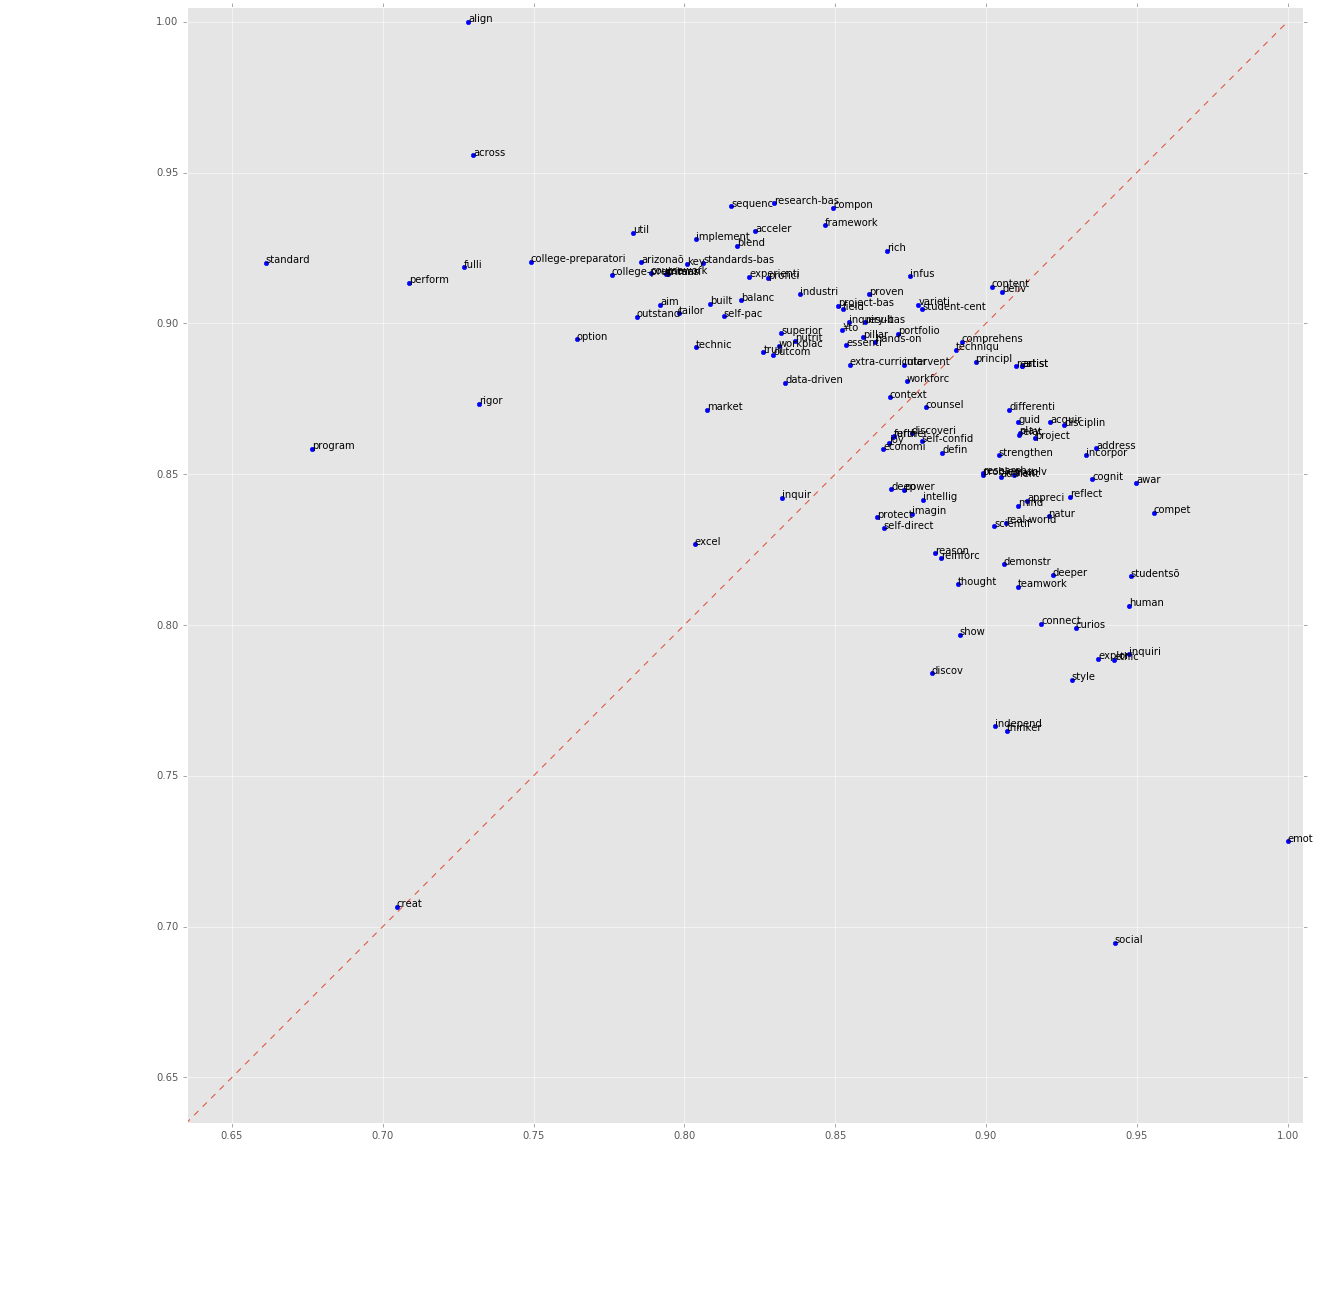

In [42]:
# here's a visual of the progressivism/essentialism binary: 
# top-left half is essentialism, bottom-right half is progressivism
_, ax = plt.subplots(figsize=(20,20))
ax.scatter(x, y, alpha=1, color='b')
for i in range(len(phil_words)):
    ax.annotate(phil_words[i], (x[i], y[i]))
ax.set_xlim(.635, 1.005)
ax.set_ylim(.635, 1.005)
plt.plot([0, 1], [0, 1], linestyle='--');

### Binary of essentialist (top-left) and progressivist (bottom-right) word vectors

## Topic Modeling with scikit-learn
> For documentation on this topic modeling (TM) package, which uses Latent Dirichlet Allocation (LDA), see [here](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html).

> And for documentation on the vectorizer package, CountVectorizer from scikit-learn, see [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [43]:
####Adopted From: 
#Author: Olivier Grisel <olivier.grisel@ensta.org>
#         Lars Buitinck
#         Chyi-Kwei Yau <chyikwei.yau@gmail.com>
# License: BSD 3 clause

# Initialize the variables needed for the topic models
n_samples = 2000
n_topics = 3
n_top_words = 50

# Create helper function that prints out the top words for each topic in a pretty way
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [44]:
# Vectorize our text using CountVectorizer
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=70, min_df=4,
                                max_features=None,
                                stop_words=stopenglish, lowercase=1
                                )

tf = tf_vectorizer.fit_transform(df.WEBTEXT)

Extracting tf features for LDA...


In [45]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

# define the lda function, with desired options
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=20,
                                learning_method='online',
                                learning_offset=80.,
                                total_samples=n_samples,
                                random_state=0)
#fit the model
lda.fit(tf)

Fitting LDA models with tf features, n_samples=2000 and n_topics=3...


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=80.0,
             max_doc_update_iter=100, max_iter=20, mean_change_tol=0.001,
             n_jobs=1, n_topics=3, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=2000, verbose=0)

In [46]:
# print the top words per topic, using the function defined above.

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model:

Topic #0:
scholars character child leadership new achievement district vision believe day values help programs self excellence families teacher ensure leaders strong respect preparatory individual small responsibility safe best others quality free learners take also process teaching campus board become family successful time texas experience reading rigorous meet focus math building prepare

Topic #1:
arts science technology leadership reading language action services provides music also young art writing middle 12 district programs day math history class time study career use english campus elementary areas classes international using knowledge course teacher understanding including activities focus new teaching first content physical personal service may challenging ib

Topic #2:
science new arts leaders summit also teacher leadership time teaching young throughout programs achievement math study approach part building class believe families focus use language 

These topics seem to mean:
- topic 0 relates to **GOALS**,
- topic 1 relates to **CURRICULUM**, and 
- topic 2 relates to **PHILOSOPHY** or learning process (but this topic less clear/ more mottled)

In [47]:
# Preparation for looking at distribution of topics over schools
topic_dist = lda.transform(tf) # transpose topic distribution
topic_dist_df = pandas.DataFrame(topic_dist) # turn into a df
df_w_topics = topic_dist_df.join(df) # merge with charter MS dataframe
df_w_topics # check out the merged df with topics!

,0,1,2,SCHNAM,ADDRESS,URL,SEARCH,CUSTOMID,WEBTEXT,LEVEL,...,webtokens,webtokens_nopunct,webtokens_clean,webtokens_stemmed,webtext_stemmed,webstem_count,webpunct_count,webclean_count,numtypes,TTR
0,131.261273,0.394623,0.344103,QUEST MIDDLE SCHOOL OF PINE BLUFF,"308 SOUTH BLAKE ST, PINE BLUFF, AR",http://responsiveed.com/questpinebluff/,QUEST MIDDLE SCHOOL OF PINE BLUFF 308 SOUTH BL...,AR3542702,Quest Middle Schools¨ are schools focused on h...,2,...,"[quest, middle, schools¨, are, schools, focuse...","[quest, middle, schools¨, are, schools, focuse...","[quest, middle, schools¨, schools, focused, hi...","[quest, middl, schools¨, school, focus, high, ...",quest middl schools¨ school focus high expect ...,200,314,200,139,0.442675
1,43.251431,0.404550,0.344018,THE ACADEMIES AT JONESBORO HIGH SCHOOL,"301 HURRICANE DR, JONESBORO, AR",http://www.jonesboroschools.net/schools/academ...,THE ACADEMIES AT JONESBORO HIGH SCHOOL 301 HUR...,AR1608703,The mission of the Academies at Jonesboro High...,3,...,"[the, mission, of, the, academies, at, jonesbo...","[the, mission, of, the, academies, at, jonesbo...","[mission, academies, jonesboro, high, school, ...","[mission, academi, jonesboro, high, school, pr...",mission academi jonesboro high school provid h...,63,111,63,71,0.639640
2,23.290207,0.367458,0.342335,A CHILD'S VIEW SCHOOL,"2846 DREXEL RD, TUCSON, AZ",http://childcarecenter.us/provider_detail/a_ch...,"A CHILD'S VIEW SCHOOL 2846 DREXEL RD, TUCSON, AZ",AZ87345,We believe that every child needs a well-round...,1,...,"[we, believe, that, every, child, needs, a, we...","[we, believe, that, every, child, needs, a, we...","[believe, every, child, needs, well-rounded, e...","[believ, everi, child, need, well-round, educ,...",believ everi child need wellround educ famili ...,38,77,38,61,0.792208
3,13.599131,5.047494,0.353375,AAEC - PARADISE VALLEY,"17811 NORTH 32ND ST, PHOENIX, AZ",http://www.aaechighschools.com/,"AAEC - PARADISE VALLEY 17811 NORTH 32ND ST, PH...",AZ6344,AAEC Early College High School prepares young ...,3,...,"[aaec, early, college, high, school, prepares,...","[aaec, early, college, high, school, prepares,...","[aaec, early, college, high, school, prepares,...","[aaec, earli, colleg, high, school, prepar, yo...",aaec earli colleg high school prepar young adu...,31,45,31,38,0.844444
4,24.045600,18.605429,0.348971,ABRAHAM LINCOLN TRADITIONAL SCHOOL,"10444 NORTH 39TH AVE, PHOENIX, AZ",http://abrahamlincoln.wesdschools.org/,ABRAHAM LINCOLN TRADITIONAL SCHOOL 10444 NORTH...,AZ5274,The mission of the Abraham Lincoln Traditional...,1,...,"[the, mission, of, the, abraham, lincoln, trad...","[the, mission, of, the, abraham, lincoln, trad...","[mission, abraham, lincoln, traditional, schoo...","[mission, abraham, lincoln, tradit, school, gu...",mission abraham lincoln tradit school guid cha...,75,106,75,71,0.669811
5,0.437738,93.213344,0.348919,ACADEMY DEL SOL,"4525 EAST BROADWAY BLVD, TUCSON, AZ",http://www.academydelsol.com/,"ACADEMY DEL SOL 4525 EAST BROADWAY BLVD, TUCSO...",AZ90200,Academy Del SolÕs mission is to provide a rigo...,1,...,"[academy, del, solõs, mission, is, to, provide...","[academy, del, solõs, mission, is, to, provide...","[academy, del, solõs, mission, provide, rigoro...","[academi, del, solõ, mission, provid, rigor, s...",academi del solõ mission provid rigor superior...,147,226,147,140,0.619469
6,196.920592,33.728109,0.351299,ACADEMY OF TUCSON ELEMENTARY SCHOOL,"9209 EAST WRIGHTSTOWN RD, TUCSON, AZ",http://www.academyoftucson.com/elementary-scho...,ACADEMY OF TUCSON ELEMENTARY SCHOOL 9209 EAST ...,AZ81130,Mission:\rIt is the purpose of the Academy of ...,1,...,"[mission, :, it, is, the, purpose, of, the, ac...","[mission, it, is, the, purpose, of, the, acade...","[mission, purpose, academy, tucson, provide, p...","[mission, purpos, academi, tucson, provid, pre...",mission purpos academi tucson provid prepar gr...,356,620,356,278,0.448387
7,24.971913,14.676298,0.351789,DESERT MOSAIC SCHOOL,"5757 WEST AJO HWY, TUC

In [48]:
topic_columns = range(0,n_topics) # Set numerical range of topic columns for use in analyses, using n_topics from above

In [49]:
# Which schools are weighted highest for topic 0? How do they trend with regard to urban proximity and student class? 
print(df_w_topics[['LSTATE', 'ULOCAL', 'PCTETH', 'PCTFRPL', 0, 1, 2]].sort_values(by=[0], ascending=False))

    LSTATE  ULOCAL     PCTETH   PCTFRPL           0            1         2
73      FL      12   0.457797  0.440629  836.884989   178.763940  0.351071
87      IL      12   0.733624  0.532751  807.866177    85.781466  0.352358
52      CA      11   0.997093  0.973837  682.823243     0.824402  0.352355
84      FL      11   0.556028  0.173050  660.449380    78.198383  0.352236
51      CA      11   0.557576  0.232323  656.232871     0.417456  0.349673
23      AZ      13   0.174312 -0.009174  571.003730     8.642115  0.354154
127     NY      11   0.989899  0.818182  563.216136    10.432775  0.351089
44      CA      11   0.810409  0.483271  530.244377     0.404822  0.350801
20      AZ      13   0.297222  0.008333  515.216903    96.431358  0.351739
180     TX      12   0.894057  0.744186  473.231776     0.421162  0.347063
22      AZ      41   0.341346  0.552885  446.228030     0.420970  0.351000
11      AZ      11 -11.250000  0.000000  401.374463   198.273555  0.351982
165     TX      11   0.96

In [50]:
# Preparation for comparing total number of words aligned with each topic
# To weight each topic by its prevalenced in the corpus, multiply each topic by the word count from above

col_list = []
for num in topic_columns:
    col = "%d_wc" % num
    col_list.append(col)
    df_w_topics[col] = df_w_topics[num] * df_w_topics['webpunct_count']
    
df_w_topics

,0,1,2,SCHNAM,ADDRESS,URL,SEARCH,CUSTOMID,WEBTEXT,LEVEL,...,webtokens_stemmed,webtext_stemmed,webstem_count,webpunct_count,webclean_count,numtypes,TTR,0_wc,1_wc,2_wc
0,131.261273,0.394623,0.344103,QUEST MIDDLE SCHOOL OF PINE BLUFF,"308 SOUTH BLAKE ST, PINE BLUFF, AR",http://responsiveed.com/questpinebluff/,QUEST MIDDLE SCHOOL OF PINE BLUFF 308 SOUTH BL...,AR3542702,Quest Middle Schools¨ are schools focused on h...,2,...,"[quest, middl, schools¨, school, focus, high, ...",quest middl schools¨ school focus high expect ...,200,314,200,139,0.442675,41216.039781,123.911766,108.048453
1,43.251431,0.404550,0.344018,THE ACADEMIES AT JONESBORO HIGH SCHOOL,"301 HURRICANE DR, JONESBORO, AR",http://www.jonesboroschools.net/schools/academ...,THE ACADEMIES AT JONESBORO HIGH SCHOOL 301 HUR...,AR1608703,The mission of the Academies at Jonesboro High...,3,...,"[mission, academi, jonesboro, high, school, pr...",mission academi jonesboro high school provid h...,63,111,63,71,0.639640,4800.908882,44.905089,38.186028
2,23.290207,0.367458,0.342335,A CHILD'S VIEW SCHOOL,"2846 DREXEL RD, TUCSON, AZ",http://childcarecenter.us/provider_detail/a_ch...,"A CHILD'S VIEW SCHOOL 2846 DREXEL RD, TUCSON, AZ",AZ87345,We believe that every child needs a well-round...,1,...,"[believ, everi, child, need, well-round, educ,...",believ everi child need wellround educ famili ...,38,77,38,61,0.792208,1793.345929,28.294249,26.359822
3,13.599131,5.047494,0.353375,AAEC - PARADISE VALLEY,"17811 NORTH 32ND ST, PHOENIX, AZ",http://www.aaechighschools.com/,"AAEC - PARADISE VALLEY 17811 NORTH 32ND ST, PH...",AZ6344,AAEC Early College High School prepares young ...,3,...,"[aaec, earli, colleg, high, school, prepar, yo...",aaec earli colleg high school prepar young adu...,31,45,31,38,0.844444,611.960911,227.137229,15.901860
4,24.045600,18.605429,0.348971,ABRAHAM LINCOLN TRADITIONAL SCHOOL,"10444 NORTH 39TH AVE, PHOENIX, AZ",http://abrahamlincoln.wesdschools.org/,ABRAHAM LINCOLN TRADITIONAL SCHOOL 10444 NORTH...,AZ5274,The mission of the Abraham Lincoln Traditional...,1,...,"[mission, abraham, lincoln, tradit, school, gu...",mission abraham lincoln tradit school guid cha...,75,106,75,71,0.669811,2548.833565,1972.175517,36.990918
5,0.437738,93.213344,0.348919,ACADEMY DEL SOL,"4525 EAST BROADWAY BLVD, TUCSON, AZ",http://www.academydelsol.com/,"ACADEMY DEL SOL 4525 EAST BROADWAY BLVD, TUCSO...",AZ90200,Academy Del SolÕs mission is to provide a rigo...,1,...,"[academi, del, solõ, mission, provid, rigor, s...",academi del solõ mission provid rigor superior...,147,226,147,140,0.619469,98.928743,21066.215642,78.855615
6,196.920592,33.728109,0.351299,ACADEMY OF TUCSON ELEMENTARY SCHOOL,"9209 EAST WRIGHTSTOWN RD, TUCSON, AZ",http://www.academyoftucson.com/elementary-scho...,ACADEMY OF TUCSON ELEMENTARY SCHOOL 9209 EAST ...,AZ81130,Mission:\rIt is the purpose of the Academy of ...,1,...,"[mission, purpos, academi, tucson, provid, pre...",mission purpos academi tucson provid prepar gr...,356,620,356,278,0.448387,122090.767038,20911.427627,217.805335
7,24.971913,14.676298,0.351789,DESERT MOSAIC SCHOOL,"5757 WEST AJO HWY, TUCSON, AZ",http://desertmosaic.com/Home_Page.php,"DESERT MOSAIC SCHOOL 5757 WEST AJO HWY, TUCSON...",AZ79118,Desert Mosaic School commits to creating a tea...,4,...,"[desert, mosaic, school, commit, creat, teach,...",desert mosaic school commit creat teach enviro...,67,115,67,74,0.643478,2871.770000,1687.774263,40.455737
8,179.458463,56.191420,0.350117,KAIZEN EDUCATION FOUNDATION DBA SUMMIT HIGH SC...,"728 EAST MCDOWELL RD, PHOENIX, AZ",http://www.summiths.com/,KAIZEN EDUCATION FOUNDATION DBA SUMMIT HIGH SC...,AZ10749,Summit High SchoolÕs Mission and Vision is to ...,3,...,"[summit, high, schoolõ, mission, vision, provi...",summit high schoolõ mission vision provid safe...,363,580,363,275,0.474138,104085.908809,32591.023578,203.067613
9,47.900249,20.751915,0.347836,OASIS HIGH SCHOOL,"8632 WEST NORTHERN AVE, GLENDALE, AZ",https://web.archive.org/web/20120617204246/htt...,"OAS

In [51]:
# Now we can see the prevalence of each topic over words for each urban category and state
grouped_urban = df_w_topics.groupby('ULOCAL')
for e in col_list:
    print(e)
    print(grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum())

grouped_state = df_w_topics.groupby('LSTATE')
for e in col_list:
    print(e)
    print(grouped_state[e].sum()/grouped_state['webpunct_count'].sum())

0_wc
ULOCAL
11    252.460199
12    344.588359
13    240.022477
21    127.201643
22     79.306683
23    138.867584
31    100.670414
32    137.660762
33     34.277186
41    146.551647
42     67.639781
dtype: float64
1_wc
ULOCAL
11    171.386633
12    318.874117
13    124.322144
21    567.652927
22    237.680326
23      0.399967
31    252.846123
32     41.157828
33    231.109223
41    228.613868
42    324.782390
dtype: float64
2_wc
ULOCAL
11    0.349413
12    0.349343
13    0.350095
21    0.348660
22    0.348461
23    0.347925
31    0.348880
32    0.348457
33    0.347473
41    0.349770
42    0.349948
dtype: float64
0_wc
LSTATE
AR    108.275173
AZ    307.060573
CA    244.894963
CO    120.827397
DC     73.747499
DE    264.251378
FL    371.423011
GA     20.119871
IL    476.761298
IN    121.664297
LA     29.510303
MA     42.715775
MD    154.503844
MI    195.752094
MN     19.651640
MO    134.226657
NC    192.330028
NJ     97.425364
NM     62.503755
NV      1.570714
NY    351.901927
OH    174.4

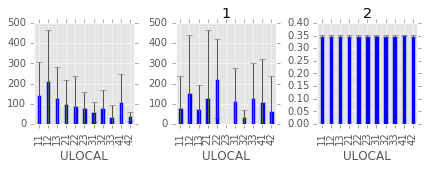

In [52]:
# Here's the distribution of urban proximity over the three topics:
fig1 = plt.figure()
chrt = 0
for num in topic_columns:
    chrt += 1 
    ax = fig1.add_subplot(2,3, chrt)
    grouped_urban[num].mean().plot(kind = 'bar', yerr = grouped_urban[num].std(), ylim=0, ax=ax, title=num)

fig1.tight_layout()
plt.show()

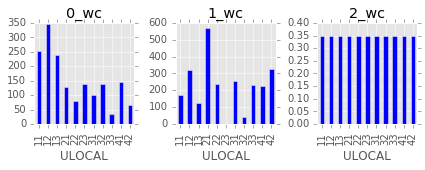

In [53]:
# Here's the distribution of each topic over words, for each urban category:
fig2 = plt.figure()
chrt = 0
for e in col_list:
    chrt += 1 
    ax2 = fig2.add_subplot(2,3, chrt)
    (grouped_urban[e].sum()/grouped_urban['webpunct_count'].sum()).plot(kind = 'bar', ylim=0, ax=ax2, title=e)

fig2.tight_layout()
plt.show()

## Preliminary conclusions: 
### Word counts:
- Website self-descriptions for schools in mid-sized cities and suburbs tend to be longest, followed by other urban and suburban schools, then schools in towns, and shortest tends to be rural schools
- Charter schools in cities and suburbs have the highest textual redundancy (lowest ratio of types to tokens)

### Word embeddings:
- The two educational philosophies I'm interested in--**progressivism** and **essentialism**--can be distinguished using semantic vectors
- Useful way for creating and checking my dictionaries

### Topic modeling:
- Urban charter schools' websites emphasize **GOALS** (topic 0)
- Suburban charter schools' websites emphasize **CURRICULUM** (topic 1) in addition to goals

## Next steps:
- Working with custom dictionaries, POS tagging
- Webscraping and parsing HTML to get full sample
- Match website text with data on test scores and community characteristics (e.g., race, class, political leanings) --> test hypotheses with statistical regression<br/><br/>
- **More long-term**: Collect longitudinal mission statement data from the Internet Archive --> look at survival and geographic dispersion of identity categories over time (especially pre-NCLB if possible)

## ...Now my questions for YOU!
### How do I differentiate _noise_ from _signal_ when scraping websites? I have a list of keywords, but the greedy analyst in me wants to take _everything_--why might this be a bad idea?
### How can CTA handle nested levels? Many charters are in charter management organizations (CMOs) with their OWN missions; a number of individual schools have minimal website self-descriptions, deferring to their CMO's values, etc. Ideas? (Structural TMs?)
### Current approach for scraping (inconsistently formatted) uses requests.get and parses HTML and for < p > tags and hrefs. One problem: How to identify relevant links in sites with no directory structure? Other suggestions to improve on this?
### How could I identify old URLs or URLs of closed schools, so I can look at old instances in the Internet Archive?
#### Less important: <br/><br/>How do I check the coherence of a dictionary? Can word2vec do this? Each dict is about 300 terms long, and I want to exclude terms that don't fit. <br/><br/> What other CTA analyses would you recommend trying out?

In [ ]:
# The keyword categories to help parse website text:
mission = ['mission',' vision ', 'vision:', 'mission:', 'our purpose', 'our ideals', 'ideals:', 'our cause', 'cause:', 'goals', 'objective']
curriculum = ['curriculum', 'curricular', 'program', 'method', 'pedagogy', 'pedagogical', 'approach', 'model', 'system', 'structure']
philosophy = ['philosophy', 'philosophical', 'beliefs', 'believe', 'principles', 'creed', 'credo', 'value',  'moral']
history = ['history', 'our story', 'the story', 'school story', 'background', 'founding', 'founded', 'established', 'establishment', 'our school began', 'we began', 'doors opened', 'school opened']
general =  ['about us', 'our school', 'who we are', 'overview', 'general information', 'our identity', 'profile', 'highlights']